In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

2025-05-22 14:12:16.432176: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-22 14:12:16.564216: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747903336.620861  457391 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747903336.640112  457391 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747903336.743713  457391 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
DATASET_PATH = "/mnt/d/Group50/Facial_Emotion_Recongnition/Datasets/VideoDataset2"
IMG_SIZE = (64, 64)
SEQUENCE_LENGTH = 20
NUM_CLASSES = 3
BATCH_SIZE = 4
EPOCHS = 30

In [3]:
class_labels = sorted(os.listdir(DATASET_PATH))
label_map = {label: idx for idx, label in enumerate(class_labels)}

In [4]:
def video_to_frames(video_path, max_frames=SEQUENCE_LENGTH):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while len(frames) < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, IMG_SIZE)
        frame = frame.astype(np.float32) / 255.0
        frames.append(frame)
    cap.release()
    while len(frames) < max_frames:
        frames.append(np.zeros((IMG_SIZE[1], IMG_SIZE[0], 3)))
    return np.array(frames)

In [ ]:
X, y = [], []
print("\U0001F4E5 Loading video data...")
for label in class_labels:
    class_dir = os.path.join(DATASET_PATH, label)
    for file in tqdm(os.listdir(class_dir), desc=f"Processing {label}"):
        if file.endswith('.mp4'):
            video_path = os.path.join(class_dir, file)
            frames = video_to_frames(video_path)
            X.append(frames)
            y.append(label_map[label])

X = np.array(X)
y = to_categorical(np.array(y), num_classes=NUM_CLASSES)

📥 Loading video data...


Processing surprise: 100%|██████████| 1714/1714 [00:15<00:00, 109.96it/s]


: 

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:

model = Sequential([
    TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(SEQUENCE_LENGTH, IMG_SIZE[0], IMG_SIZE[1], 3)),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Conv2D(64, (3, 3), activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Flatten()),
    LSTM(64),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/home/group50/anaconda3/envs/condaenv/lib/python3.11/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1747902498.109603  228352 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13512 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 62, 62, 32) │           896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 31, 31, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 29, 29, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 20, 14, 14, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 20, 12544)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │     3,227,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,251,586 (12.40 MB)

 Trainable params: 3,251,586 (12.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=32,
)

NameError: name 'model' is not defined

In [ ]:
plot_model(model, to_file='model_layout.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.save('emotion_cnn_lstm_model.h5')
print("✅ Model saved!")

New Code

In [1]:
import os
import numpy as np
import cv2
import json
from tqdm import tqdm

DATASET_PATH = "/mnt/d/Group50/Facial_Emotion_Recongnition/Datasets/VideoDataset2"
OUTPUT_PATH = "processed_videos"
MAX_FRAMES = 30
IMG_SIZE = (64, 64)

os.makedirs(OUTPUT_PATH, exist_ok=True)

metadata = []

def video_to_frames(video_path, max_frames=MAX_FRAMES):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while len(frames) < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, IMG_SIZE)
        frame = frame / 255.0  # Normalize
        frames.append(frame)
    cap.release()
    
    # Pad if fewer than max_frames
    while len(frames) < max_frames:
        frames.append(np.zeros((IMG_SIZE[1], IMG_SIZE[0], 3)))
    
    return np.array(frames)

# Save .npy files and metadata
for label in os.listdir(DATASET_PATH):
    class_dir = os.path.join(DATASET_PATH, label)
    for file in tqdm(os.listdir(class_dir), desc=f"Processing {label}"):
        if file.endswith(".mp4"):
            video_path = os.path.join(class_dir, file)
            frames = video_to_frames(video_path)
            video_id = os.path.splitext(file)[0]
            out_file = os.path.join(OUTPUT_PATH, f"{video_id}.npy")
            np.save(out_file, frames)
            metadata.append({"video_id": video_id, "label": label})

# Save metadata
with open(os.path.join(OUTPUT_PATH, "metadata.json"), "w") as f:
    json.dump(metadata, f)


Processing surprise: 100%|██████████| 1714/1714 [00:41<00:00, 41.41it/s]


In [4]:
import json
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Load metadata
with open(os.path.join(OUTPUT_PATH, "metadata.json"), "r") as f:
    metadata = json.load(f)

# Encode labels
labels = [item["label"] for item in metadata]
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

# Add encoded labels to metadata
for i, item in enumerate(metadata):
    item["label_encoded"] = int(y_encoded[i])  # Convert to Python int


# Save updated metadata
with open(os.path.join(OUTPUT_PATH, "metadata_encoded.json"), "w") as f:
    json.dump(metadata, f)



In [5]:
import tensorflow as tf
import numpy as np

class VideoDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, metadata, batch_size, num_classes, data_path, shuffle=True):
        self.metadata = metadata
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.data_path = data_path
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.metadata) / self.batch_size))

    def __getitem__(self, index):
        batch_metadata = self.metadata[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_metadata)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.metadata)

    def __data_generation(self, batch_metadata):
        X = []
        y = []
        for item in batch_metadata:
            file_path = os.path.join(self.data_path, f"{item['video_id']}.npy")
            frames = np.load(file_path)
            X.append(frames)
            y.append(item["label_encoded"])
        X = np.array(X)
        y = to_categorical(y, num_classes=self.num_classes)
        return X, y


In [6]:
# Load encoded metadata
with open(os.path.join(OUTPUT_PATH, "metadata_encoded.json"), "r") as f:
    metadata = json.load(f)

# Split into train/val
from sklearn.model_selection import train_test_split
train_meta, val_meta = train_test_split(metadata, test_size=0.2, random_state=42)

# Generators
train_gen = VideoDataGenerator(train_meta, batch_size=8, num_classes=num_classes, data_path=OUTPUT_PATH)
val_gen = VideoDataGenerator(val_meta, batch_size=8, num_classes=num_classes, data_path=OUTPUT_PATH)

# Build model (example)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense

model = Sequential([
    TimeDistributed(Conv2D(16, (3, 3), activation='relu'), input_shape=(MAX_FRAMES, IMG_SIZE[1], IMG_SIZE[0], 3)),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Flatten()),
    LSTM(64),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
model.fit(train_gen, validation_data=val_gen, epochs=10)


/home/group50/anaconda3/envs/condaenv/lib/python3.11/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1747904636.631589  542302 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13512 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/group50/anaconda3/envs/condaenv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1747904641.166638  626201 cuda_dnn.cc:529] Loaded cuDNN version 90300


515/515 ━━━━━━━━━━━━━━━━━━━━ 61s 110ms/step - accuracy: 0.4034 - loss: 1.0867 - val_accuracy: 0.4985 - val_loss: 0.9986
Epoch 2/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 53s 103ms/step - accuracy: 0.6336 - loss: 0.7914 - val_accuracy: 0.7211 - val_loss: 0.6286
Epoch 3/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 56s 107ms/step - accuracy: 0.8445 - loss: 0.4132 - val_accuracy: 0.7804 - val_loss: 0.5192
Epoch 4/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 52s 101ms/step - accuracy: 0.9338 - loss: 0.2055 - val_accuracy: 0.8251 - val_loss: 0.4599
Epoch 5/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 56s 108ms/step - accuracy: 0.9739 - loss: 0.0962 - val_accuracy: 0.8144 - val_loss: 0.5394
Epoch 6/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 56s 109ms/step - accuracy: 0.9799 - loss: 0.0648 - val_accuracy: 0.7911 - val_loss: 0.6656
Epoch 7/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 57s 111ms/step - accuracy: 0.9897 - loss: 0.0406 - val_accuracy: 0.8445 - val_loss: 0.5846
Epoch 8/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 56s 109ms/step - accuracy: 0.9893 - loss: 0.0347 - val

In [9]:
model.save('emotion_cnn_lstm_model.h5')
print("✅ Model saved!")

✅ Model saved!


NameError: name 'history' is not defined

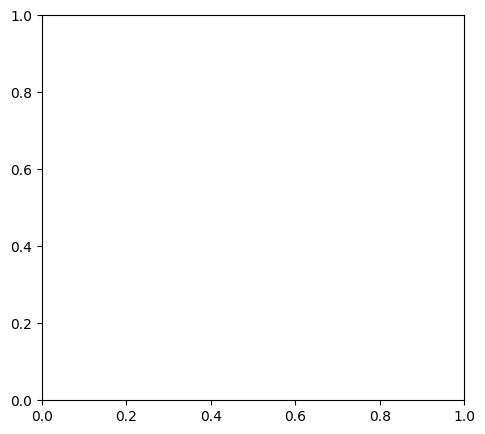

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.model['accuracy'], label='Train Accuracy')
plt.plot(history.model['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
model = load_model('emotion_cnn_lstm_model.h5')
cap = cv2.VideoCapture(0)
sequence = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        face = frame[y:y+h, x:x+w]
        face = cv2.resize(face, IMG_SIZE)
        face = face.astype(np.float32) / 255.0
        sequence.append(face)
        if len(sequence) == SEQUENCE_LENGTH:
            input_seq = np.expand_dims(sequence, axis=0)
            preds = model.predict(input_seq)
            emotion = class_labels[np.argmax(preds)]
            cv2.putText(frame, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
            sequence = []
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
    cv2.imshow('Real-time Emotion Detection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()